# UCI Heart Disease (Cleveland) dataset: binary outcome ML classifier 

This notebook is a portfolio-style, end-to-end machine learning walkthrough using the UCI Heart Disease (Cleveland) dataset with a binary outcome (target: disease vs no disease). 
The **goal is to build a clinically relevant classifier**.

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import (
    train_test_split, KFold, LeaveOneOut, cross_val_score,
    GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)

import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ritwikb3/heart-disease-cleveland")
os.listdir(path)

['Heart_disease_cleveland_new.csv']

In [5]:
df = pd.read_csv(os.path.join(path, "Heart_disease_cleveland_new.csv"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB



* **Age**: Patients Age in years (Numeric)
* **Sex**: Gender (Male : 1; Female : 0) (Nominal)
* **cp**: Type of chest pain experienced by patient. This term categorized into 4 category.
    0 typical angina, 1 atypical angina, 2 non- anginal pain, 3 asymptomatic (Nominal)
* **trestbps**: patient's level of blood pressure at resting mode in mm/HG (Numerical)
* **chol**: Serum cholesterol in mg/dl (Numeric)
* **fbs**: Blood sugar levels on fasting > 120 mg/dl represents as 1 in case of true and 0 as false (Nominal)
* **restecg**: Result of electrocardiogram while at rest are represented in 3 distinct values
    0 : Normal 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    2: showing probable or definite left ventricular hypertrophyby Estes' criteria (Nominal)
* **thalach**: Maximum heart rate achieved (Numeric)
* **exang**: Angina induced by exercise 0 depicting NO 1 depicting Yes (Nominal)
* **oldpeak**: Exercise induced ST-depression in relative with the state of rest (Numeric)
* **slope**: ST segment measured in terms of slope during peak exercise
    0: up sloping; 1: flat; 2: down sloping(Nominal)
* **ca**: The number of major vessels (0–3)(nominal)
* **thal**: A blood disorder called thalassemia
    0: NULL 1: normal blood flow 2: fixed defect (no blood flow in some part of the heart) 3: reversible defect (a blood flow is observed but it is not normal(nominal)
* **target**: It is the target variable which we have to predict 1 means patient is suffering from heart disease and 0 means patient is normal.


The outcome is binary, making this a supervised classification problem.

As False negatives are costly (missed disease), recall (sensitivity) and ROC‑AUC are emphasized.

Let's standardize numeric variables and one-hot encode categorical variables to ensure proper feature scaling and comparability using the ColumnTransformer.

Then the dataset is seperated between train and test data ensuring the distribution of the outcome stays similar to the total dataset (stratify=y).

In [6]:
target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Identify categorical vs numeric
cat_cols = ["sex","cp","fbs","restecg", "exang","slope","ca","thal"]
num_cols = ["age", "trestbps","chol","thalach","oldpeak"]

print("Shape:", df.shape)
print("Target prevalence:", y.mean().round(3))
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Preprocess: scale numeric, one-hot encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Shape: (303, 14)
Target prevalence: 0.459
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


## 1. Logistic regression

The function evaluate_binary computes threshold-dependent metrics (precision, recall, F1 at 0.5) and threshold-free discrimination ROC-AUC. 



=== Baseline: Logistic Regression ===
{'roc_auc': 0.939, 'precision': 0.889, 'recall': 0.857, 'f1': 0.873}


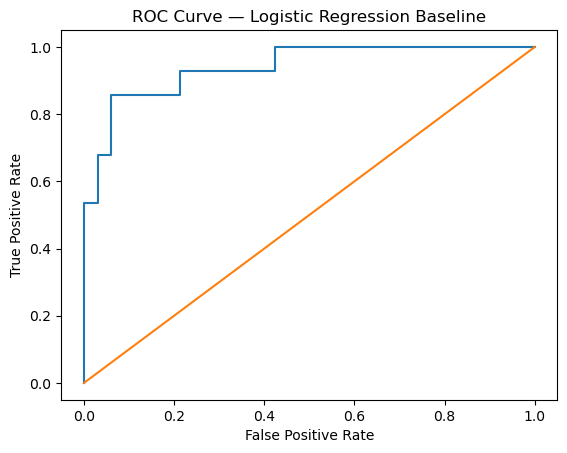

In [7]:
# Utility: evaluate classifier with core metrics
def evaluate_binary(model, X_te, y_te, threshold=0.5):
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_te, proba),
        "precision": precision_score(y_te, pred),
        "recall": recall_score(y_te, pred),
        "f1": f1_score(y_te, pred),
        "proba": proba,
        "pred": pred
    }

def plot_confusion(cm, title):
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0,1], ["No", "Yes"])
    plt.yticks([0,1], ["No", "Yes"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.show()



# Baseline classification + ROC / PR visualizations

baseline_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

baseline_lr.fit(X_train, y_train)
base_res = evaluate_binary(baseline_lr, X_test, y_test)

print("\n=== Baseline: Logistic Regression ===")
print({k: round(v, 3) for k, v in base_res.items() if k in ["roc_auc","precision","recall","f1"]})

# ROC curve
fpr, tpr, _ = roc_curve(y_test, base_res["proba"])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.title("ROC Curve — Logistic Regression Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

ROC-AUC = 0.939
The ROC curve shows good separation between patients with and without heart disease. 

Precision = 0.889, Recall = 0.857, F1 = 0.873
At the default 0.5 threshold, the model achieves a good balance between false positives and false negatives. 

In general, **high recall is particularly desirable in a screening context, where missing true disease cases is costly**.

The ROC Curve Visualization lies well above the diagonal (random classifier), confirming substantial predictive signal even with a simple linear model.

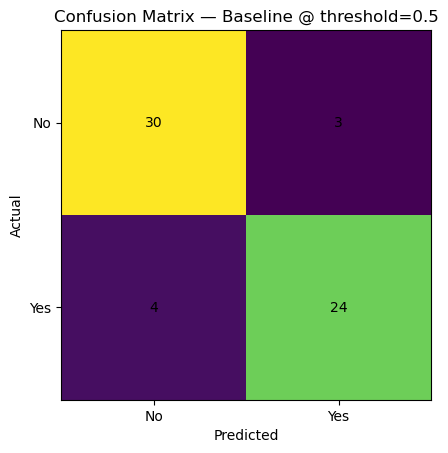

In [8]:
# Confusion matrix at 0.5
cm = confusion_matrix(y_test, base_res["pred"])
plot_confusion(cm, "Confusion Matrix — Baseline @ threshold=0.5")

The confusion matrix shows us **we still miss 4 cases out of 28 cases. This may be too high.**

The **Precision–Recall (PR) curve** provides a complementary view to ROC analysis, particularly relevant when class balance matters and false positives carry cost. For the logistic regression baseline, the Average Precision (AP) of 0.889 indicates good performance across recall levels.

At lower recall values, the model maintains a good precision, meaning that positive predictions are rarely false positives. As recall increases toward 1.0, precision gradually declines, reflecting the expected tradeoff when the decision threshold is lowered to capture nearly all true disease cases.

The curve’s shape shows that the model preserves high precision even at moderately high recall levels, which is desirable in a clinical screening context.

Overall, the Precision–Recall curve confirms that logistic regression provides a strong, reliable baseline before introducing more complex nonlinear or ensemble models.

**As 4 cases were missed, what happens if we may want to decrease the threshold to get for instance a recall of 0.9?**

In [69]:
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
def threshold_for_target_recall(y_true, y_proba, target_recall=0.90):
    """
    Find the lowest decision threshold that achieves at least target_recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # thresholds has length len(recall) - 1
    for r, t in zip(recall[:-1], thresholds):
        if r >= target_recall:
            return t

    # If target recall is never reached, fall back to lowest threshold
    return thresholds[-1]
proba_test = baseline_lr.predict_proba(X_test)[:, 1]
target_recall = 0.90
chosen_threshold = threshold_for_target_recall(
    y_test, proba_test, target_recall
)

print("Chosen threshold for recall ≥", target_recall, ":", round(chosen_threshold, 3))
res_recall_optimized = evaluate_binary(
    baseline_lr,
    X_test,
    y_test,
    threshold=chosen_threshold
)

print("\n=== Logistic Regression (Recall-Optimized) ===")
print({
    k: round(v, 3)
    for k, v in res_recall_optimized.items()
    if k in ["roc_auc", "precision", "recall", "f1"]
})

Chosen threshold for recall ≥ 0.9 : 0.009

=== Logistic Regression (Recall-Optimized) ===
{'roc_auc': 0.939, 'precision': 0.459, 'recall': 1.0, 'f1': 0.629}


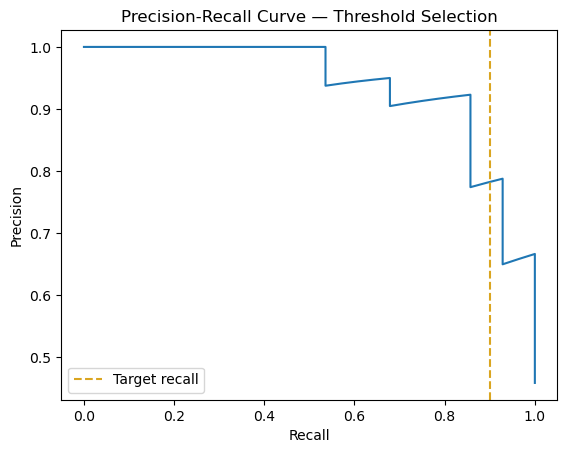

In [70]:
prec, rec, thresholds = precision_recall_curve(y_test, proba_test)

plt.figure()
plt.plot(rec, prec)
plt.axvline(target_recall, color='goldenrod',linestyle="--", label="Target recall")
plt.title("Precision-Recall Curve — Threshold Selection")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

Then **precision and F1 drop, but recall increases. ROC AUC is unchanged.**

Threshold is 0.009 classifying almost everyone as positive.

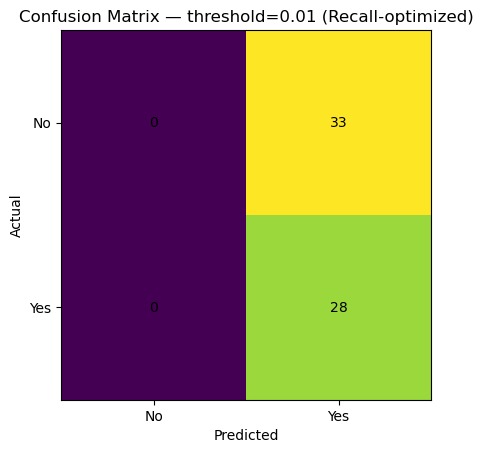

In [14]:
cm = confusion_matrix(y_test, res_recall_optimized["pred"])
plot_confusion(
    cm,
    f"Confusion Matrix — threshold={chosen_threshold:.2f} (Recall-optimized)"
)

The confusion matrix shows now there are **no more False Negatives nor True Negatives but False Positives have increased tremendously**.

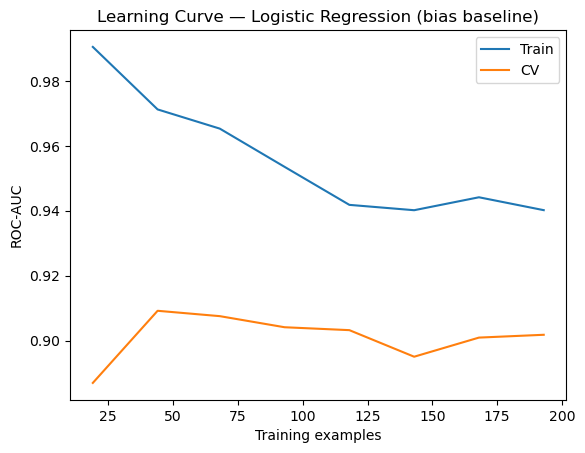

In [18]:
def plot_learning_curve_auc(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        cv=5, scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1))
    plt.plot(train_sizes, val_scores.mean(axis=1))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC")
    plt.legend(["Train", "CV"])
    plt.show()

rf_basic = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1))
])

svm_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", probability=True))
])

plot_learning_curve_auc(baseline_lr, "Learning Curve — Logistic Regression (bias baseline)")

These learning curves compare training vs cross-validation ROC-AUC as the number of training examples increases, providing insight into bias, variance, and data efficiency for different model classes.

The logistic regression model shows moderately high training performance with a persistent gap to cross-validation performance. As more data is added, CV ROC-AUC steadily deteriorates, but the gap does not fully close.

This pattern is characteristic of a **high-bias model**. Logistic regression’s linear decision boundary limits its capacity to capture nonlinear relationships, so additional data cannot fully overcome model bias.

Let's have a quick look at optimization behavior of logistic regression under two gradient descent strategies, batch and stochastic gradient descent.

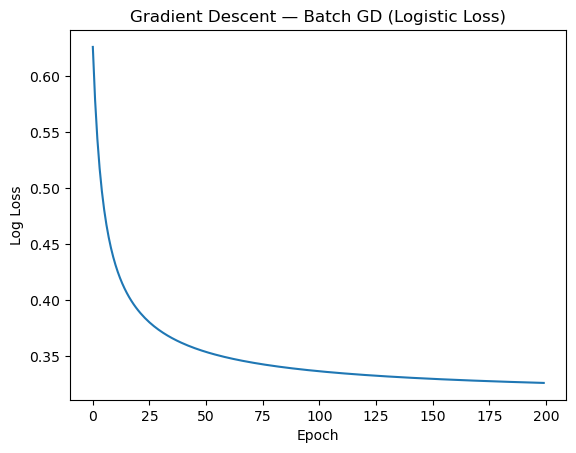

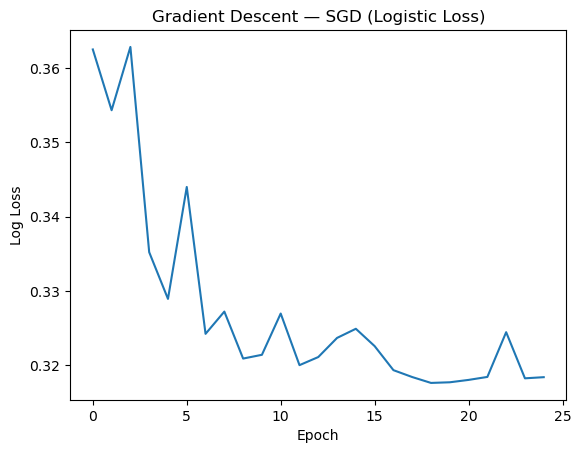

SGDClassifier ROC-AUC: 0.939


In [21]:
X_train_proc = preprocess.fit_transform(X_train)
X_train_dense = (
    X_train_proc.toarray()
    if hasattr(X_train_proc, "toarray")
    else X_train_proc
)
ytr = y_train.values.astype(float)

# Add intercept term
Xgd = np.c_[np.ones(X_train_dense.shape[0]), X_train_dense]


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def log_loss(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(
        y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)
    )


def batch_gd_logistic(X, y, lr=0.3, epochs=200):
    w = np.zeros(X.shape[1])
    losses = []

    for _ in range(epochs):
        p = sigmoid(X @ w)
        grad = (X.T @ (p - y)) / len(y)
        w -= lr * grad
        losses.append(log_loss(y, sigmoid(X @ w)))

    return w, np.array(losses)


def sgd_logistic(X, y, lr=0.05, epochs=25):
    w = np.zeros(X.shape[1])
    losses = []
    idx = np.arange(len(y))

    for _ in range(epochs):
        np.random.shuffle(idx)
        for i in idx:
            p = sigmoid(X[i] @ w)
            grad = (p - y[i]) * X[i]
            w -= lr * grad
        losses.append(log_loss(y, sigmoid(X @ w)))

    return w, np.array(losses)


w_bgd, loss_bgd = batch_gd_logistic(Xgd, ytr)
w_sgd, loss_sgd = sgd_logistic(Xgd, ytr)

plt.figure()
plt.plot(loss_bgd)
plt.title("Gradient Descent — Batch GD (Logistic Loss)")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()

plt.figure()
plt.plot(loss_sgd)
plt.title("Gradient Descent — SGD (Logistic Loss)")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()


# Practical SGDClassifier (no random_state)
sgd_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SGDClassifier(loss="log_loss", alpha=1e-4, max_iter=5000))
])

sgd_clf.fit(X_train, y_train)
sgd_proba = sgd_clf.predict_proba(X_test)[:, 1]

print("SGDClassifier ROC-AUC:",
      round(roc_auc_score(y_test, sgd_proba), 3))



These plots illustrate the optimization behavior of logistic regression under two gradient descent strategies.

**Batch Gradient Descent** shows a smooth, monotonic decrease in log loss. Because the gradient is computed using the entire training set at each step, updates are stable but computationally expensive, especially as dataset size grows.

**Stochastic Gradient Descent (SGD)** exhibits noticeable noise in the loss trajectory. This variability is expected, as each update is based on a single (or small batch of) observation(s), introducing stochasticity into the optimization process.

The trained SGDClassifier achieves a ROC-AUC of 0.939, indicating strong discriminative performance that is close but slightly lower than the closed-form logistic regression baseline.

In [65]:
l2_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(penalty="l2", C=1.0, solver="liblinear", max_iter=2000))
])
l1_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=2000))
])

l2_lr.fit(X_train, y_train)
l1_lr.fit(X_train, y_train)

l2_auc = roc_auc_score(y_test, l2_lr.predict_proba(X_test)[:, 1])
l1_auc = roc_auc_score(y_test, l1_lr.predict_proba(X_test)[:, 1])
print("\n=== Regularization ===")
print("L2 ROC-AUC:", round(l2_auc, 3))
print("L1 ROC-AUC:", round(l1_auc, 3))

# Coefficient sparsity for L1 (feature selection effect)
coef_l1 = l1_lr.named_steps["clf"].coef_.ravel()
sparsity = np.mean(np.isclose(coef_l1, 0.0))
print("L1 sparsity (fraction zero coefs):", round(float(sparsity), 3))


=== Regularization ===
L2 ROC-AUC: 0.939
L1 ROC-AUC: 0.944
L1 sparsity (fraction zero coefs): 0.464


**L1 “lasso” penalty** drives 46% coefficients to 0,  performing **feature selection** which can improve interpretability (fewer active features). It achieves a **higher ROC-AUC of 0.944**.

**L2 “ridge” penalty** shrinks coefficients smoothly toward zero, preserving information across correlated features. Here it doesn't improve the ROC-AUC.

We can have a look at the **most important non-zero L1 features**:

In [66]:
# Get feature names after preprocessing
prep = l1_lr.named_steps["prep"]

num_features = prep.named_transformers_["num"].get_feature_names_out()
cat_features = prep.named_transformers_["cat"].get_feature_names_out()

feature_names = np.concatenate([num_features, cat_features])

# Extract coefficients
coef = l1_lr.named_steps["clf"].coef_.ravel()

# Create DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# Keep only non-zero coefficients
non_zero = coef_df[coef_df["coefficient"] != 0]

top_l1_features = (
    non_zero
    .assign(abs_coef=lambda x: np.abs(x["coefficient"]))
    .sort_values("abs_coef", ascending=False)
    .drop(columns="abs_coef")
)

print("\nTop non-zero L1 features:")
print(top_l1_features.head(15))


Top non-zero L1 features:
      feature  coefficient
21       ca_0    -1.802688
10       cp_3     1.466456
5       sex_0    -1.036398
27     thal_3     0.977899
19    slope_1     0.824995
16    exang_0    -0.534937
4     oldpeak     0.503848
3     thalach    -0.380106
1    trestbps     0.290548
13  restecg_0    -0.261601
6       sex_1     0.225983
23       ca_2     0.164000
17    exang_1     0.140287
2        chol     0.092987
7        cp_0    -0.011865


We can see that the most important features are:
* 0 major vessels
* the absence of chest pain,
* female sex,
* thalassemia reversible defect, 
* flat ST segment and 

## 2. Random forest

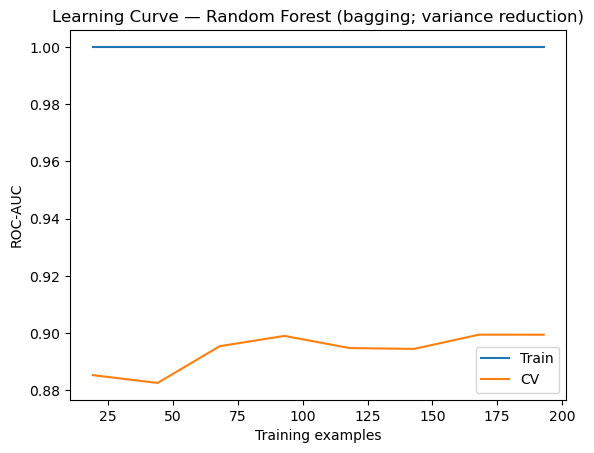

In [44]:
plot_learning_curve_auc(rf_basic, "Learning Curve — Random Forest (bagging; variance reduction)")

The random forest exhibits near-perfect training ROC-AUC, while cross-validation performance improves more slowly and remains noticeably lower.

This indicates a low-bias, higher-variance model. Bagging substantially reduces variance compared to individual trees, but the remaining gap suggests some overfitting, especially in smaller data regimes. As training size increases, variance decreases and CV performance improves.

Let's have a look to **feature importance** using Mean Decrease in Impurity (MDI) / Gini to find out the strongest predictors of heart disease. These features reduce classification uncertainty across trees, indicating high discriminative value, but the direction of the effect is not given.

In [86]:
rf_basic.named_steps["clf"].criterion

'gini'

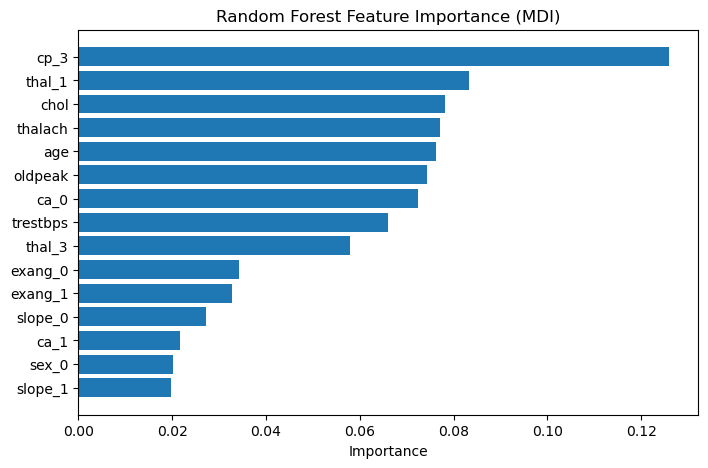

In [49]:
# Numeric feature names
num_features = num_cols
# One-hot encoded categorical names
cat_features = (
    rf_basic.named_steps["prep"]
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

feature_names = np.concatenate([num_features, cat_features])
importances = rf_basic.named_steps["clf"].feature_importances_

importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)
plt.figure(figsize=(8, 5))
plt.barh(
    importance_df.head(15)["feature"],
    importance_df.head(15)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (MDI)")
plt.xlabel("Importance")
plt.show()

In [45]:
ada = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", AdaBoostClassifier(n_estimators=400))
])

rf_basic.fit(X_train, y_train)
ada.fit(X_train, y_train)

rf_auc = roc_auc_score(y_test, rf_basic.predict_proba(X_test)[:, 1])
ada_auc = roc_auc_score(y_test, ada.predict_proba(X_test)[:, 1])

results = [("Random Forest (Bagging)", rf_auc), ("AdaBoost (Boosting)", ada_auc)]

AdaBoost focuses on reducing bias by iteratively reweighting misclassified observations. While it improves over simple linear baselines, its lower ROC-AUC suggests sensitivity to noise and outliers in this dataset, which can limit generalization performance.

We can see that the **most important features** in the Random forest model are:
* the absence of chest pain (probably negative direction), 
* normal blood flow (probably similar), 
* cholesterol, 
* Maximum heart rate and 
* age.
This is **different from the L1 model above**!

Let's look at **Ada Boost**. 

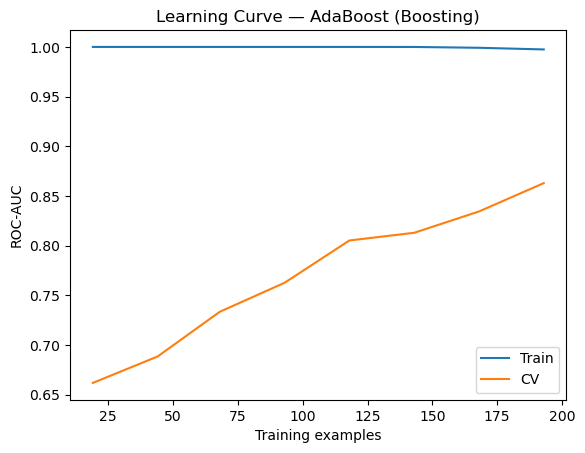

In [51]:
plot_learning_curve_auc(
    ada,
    "Learning Curve — AdaBoost (Boosting)"
)

Let's try **XGBoost**.

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score

def roc_auc_from_proba(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, proba)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

scores = cross_val_score(
    xgb_basic,
    X_train, y_train,
    cv=cv,
    scoring=roc_auc_from_proba,   # <-- bypass sklearn response_method logic
    n_jobs=1,
    error_score="raise"
)

xgb_cv_scores = np.array(scores)   # ensure numpy array
xgb_mean_auc = xgb_cv_scores.mean()
print("CV AUC scores:", scores)
print("mean:", scores.mean(), "std:", scores.std())

CV AUC scores: [0.90909091 0.92424242 0.83164983 0.86868687 0.86195286]
mean: 0.8791245791245792 std: 0.03344029365100376


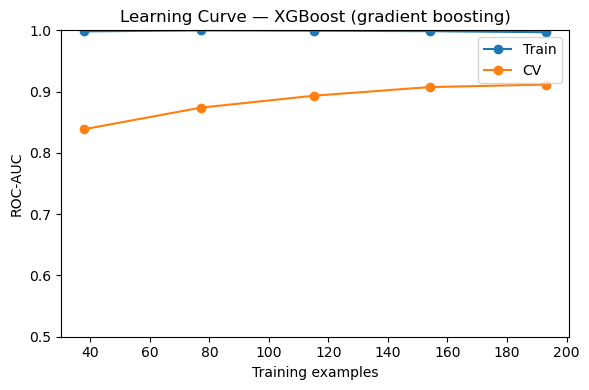

In [31]:
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

def roc_auc_from_proba(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, proba)

def plot_learning_curve_auc_callable(estimator, title):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X_train, y_train,
        cv=cv,
        scoring=roc_auc_from_proba,         # <-- callable scorer
        train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
        n_jobs=1,
        shuffle=True,
        error_score="raise"
    )

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), marker="o")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), marker="o")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC")
    plt.legend(["Train", "CV"])
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()

plot_learning_curve_auc_callable(
    xgb_basic,
    "Learning Curve — XGBoost (gradient boosting)"
)

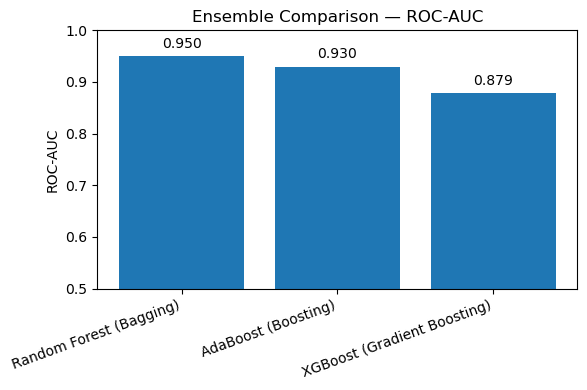

In [50]:
results = [
    ("Random Forest (Bagging)", rf_auc),
    ("AdaBoost (Boosting)", ada_auc),
    ("XGBoost (Gradient Boosting)", xgb_mean_auc)
]
plt.figure(figsize=(6, 4))

names = [r[0] for r in results]
values = [r[1] for r in results]

bars = plt.bar(names, values)

plt.title("Ensemble Comparison — ROC-AUC")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=20, ha="right")

# Add values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

**Random Forest** is the **strongest discriminator here**. 

**AdaBoost** is competitive but slightly weaker.

**XGBoost** underperforms here, maybe because the dataset is not large enough.

In general, **Bagging** reduces variance by averaging many independent models, while **boosting** reduces bias by sequentially fixing mistakes made by earlier models. So Bias reduction was maybe not the bottleneck here.

To estimate **uncertainty of ROC-AUC** we can use **bootstrapping**: we fit the model once, then resample the test set with replacement many times and recompute AUC each time.

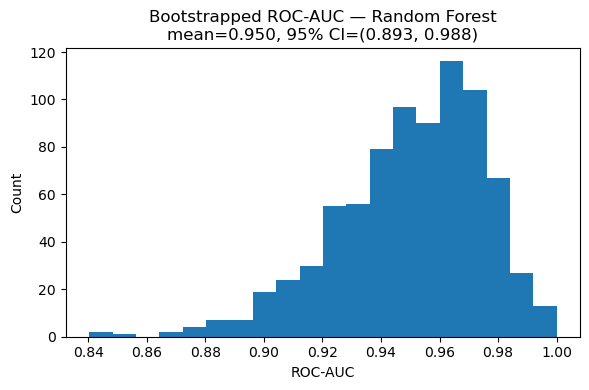

RF mean AUC: 0.95 CI: (np.float64(0.893), np.float64(0.988))


In [52]:
def get_scores(model, X):
    """Return continuous scores for ROC-AUC (prefer proba, else decision function)."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        raise ValueError("Model must implement predict_proba or decision_function.")

def bootstrap_auc_ci(model, X_te, y_te, n_boot=1000, alpha=0.05):
    X_te = X_te.reset_index(drop=True)
    y_te = pd.Series(y_te).reset_index(drop=True)
    n = len(y_te)

    aucs = []
    for _ in range(n_boot):
        idx = np.random.randint(0, n, size=n)   # sample with replacement
        scores = get_scores(model, X_te.iloc[idx])
        aucs.append(roc_auc_score(y_te.iloc[idx], scores))

    aucs = np.array(aucs)
    lo, hi = np.quantile(aucs, [alpha/2, 1 - alpha/2])
    return aucs.mean(), lo, hi, aucs

def plot_bootstrap_auc(aucs, mean_auc, lo, hi, title):
    plt.figure(figsize=(6,4))
    plt.hist(aucs, bins=20)
    plt.title(f"{title}\nmean={mean_auc:.3f}, 95% CI=({lo:.3f}, {hi:.3f})")
    plt.xlabel("ROC-AUC")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Random Forest
rf_mean, rf_lo, rf_hi, rf_aucs = bootstrap_auc_ci(rf_basic, X_test, y_test, n_boot=800)
plot_bootstrap_auc(rf_aucs, rf_mean, rf_lo, rf_hi, "Bootstrapped ROC-AUC — Random Forest")

print("RF mean AUC:", round(rf_mean, 3), "CI:", (round(rf_lo, 3), round(rf_hi, 3)))

The **bootstrapped ROC-AUC distribution** shows that the **Random Forest achieves consistently excellent discrimination** (mean ≈ 0.95) with a tight 95% confidence interval, indicating stable and trustworthy performance.


Let's look at **K-Fold CV** to **estimate generalization performance** (how well the model will do on new data) while using training data efficiently. We split data into folds and refit model K times on different training subsets, score on the held-out fold each time to get a set of K validation scores.

=== 10-Fold CV (Random Forest) ===
Fold ROC-AUC: [0.84  0.876 0.847 0.905 0.897 0.911 0.893 0.982 0.949 0.958]
Mean / Std  : 0.906 / 0.044


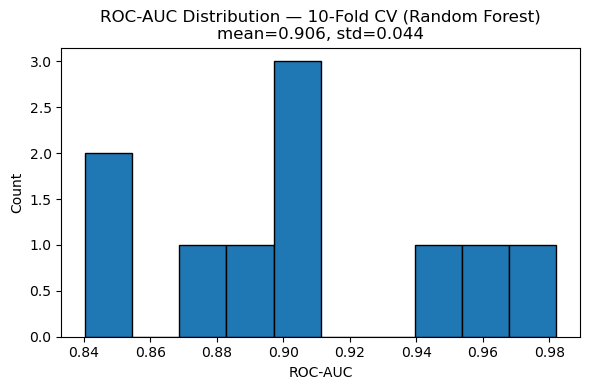

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Random Forest pipeline (no RANDOM_STATE)
rf_basic = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        n_jobs=-1
    ))
])

# Stratified K-Fold (no random_state)
skf = StratifiedKFold(n_splits=10, shuffle=True)

# Cross-validated ROC-AUC scores
rf_cv_scores = cross_val_score(
    rf_basic,
    X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("=== 10-Fold CV (Random Forest) ===")
print("Fold ROC-AUC:", np.round(rf_cv_scores, 3))
print("Mean / Std  :", round(rf_cv_scores.mean(), 3), "/", round(rf_cv_scores.std(), 3))

# Plot distribution
plt.figure(figsize=(6, 4))
plt.hist(rf_cv_scores, bins=10, edgecolor="black")
plt.title(
    f"ROC-AUC Distribution — 10-Fold CV (Random Forest)\n"
    f"mean={rf_cv_scores.mean():.3f}, std={rf_cv_scores.std():.3f}"
)
plt.xlabel("ROC-AUC")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

10-Fold CV shows that Random Forest generalizes well, with strong average discrimination and acceptable variability, with highest folds suggesting the model can perform extremely well when data is favorable.

Let's look at **randomized search** and **grid search** for random forrest tuning of hyperparameters.

In [68]:
param_dist = {
    "clf__n_estimators": [200, 400, 800, 1200],
    "clf__max_depth": [None, 3, 5, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}

from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    estimator=rf_basic,
    param_distributions=param_dist,
    n_iter=20,              # number of random configs tried
    cv=5,                   # 5-fold cross-validation
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

print("Best CV ROC-AUC:", round(rs.best_score_, 3))
print("Best parameters:", rs.best_params_)

best_rf = rs.best_estimator_
test_auc = roc_auc_score(
    y_test,
    best_rf.predict_proba(X_test)[:, 1]
)

print("Test ROC-AUC:", round(test_auc, 3))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV ROC-AUC: 0.91
Best parameters: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 12}
Test ROC-AUC: 0.937


In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Base pipeline (same as rf_basic)
rf_basic = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_jobs=-1))
])

# Grid (smaller & structured — grid search is expensive)
param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

gs = GridSearchCV(
    rf_basic,
    param_grid=param_grid,
    cv=5,                       # ✅ K-fold CV
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

gs.fit(X_train, y_train)

print("\n=== Grid Search (Random Forest) ===")
print("Best params:", gs.best_params_)
print("Best CV ROC-AUC:", round(gs.best_score_, 3))


=== Grid Search (Random Forest) ===
Best params: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 200}
Best CV ROC-AUC: 0.915


The untuned RF performs extremely well compared to gridsearch and randomsearch models on this dataset, which can be optimistic.

## 3. SVM

In [73]:
svm_linear = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="linear", probability=True))
])
svm_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", probability=True))
])

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
auc_lin = roc_auc_score(y_test, svm_linear.predict_proba(X_test)[:, 1])
auc_rbf = roc_auc_score(y_test, svm_rbf.predict_proba(X_test)[:, 1])

print("\n=== SVM Kernels ===")
print("SVM Linear ROC-AUC:", round(auc_lin, 3))
print("SVM RBF    ROC-AUC:", round(auc_rbf, 3))


=== SVM Kernels ===
SVM Linear ROC-AUC: 0.945
SVM RBF    ROC-AUC: 0.92


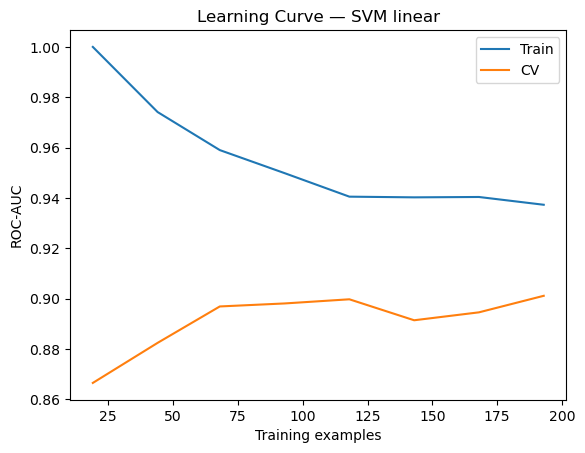

In [62]:
plot_learning_curve_auc(svm_linear, "Learning Curve — SVM linear")

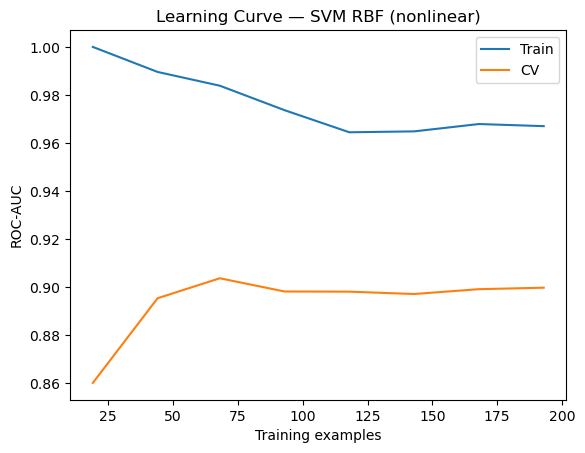

In [63]:
plot_learning_curve_auc(svm_rbf, "Learning Curve — SVM RBF (nonlinear)")

Despite RBF being more flexible, the linear SVM performs better and more reliably on this dataset, capturing most of the signal without overfitting and producing robust discrimination. The RBF SVM learns complex patterns but maybe at the cost of stability and generalization, adding variance, not signal.

## 4. Neural network

Let's use now a **Multilayer Perceptron (MLP)**, a foundational feedforward artificial neural network consisting of an input layer, one or more hidden layers, and an output layer, where all nodes are fully connected.

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline

# MLP 
mlp = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        solver="adam",
        alpha=1e-3,               # L2 regularization (weight decay)
        learning_rate_init=1e-3,
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.2,  # split from X_train only
        n_iter_no_change=20,
        random_state=42
    ))
])

In [78]:
# 14.2) Train + evaluate on test set
mlp.fit(X_train, y_train)
mlp_res = evaluate_binary(mlp, X_test, y_test, threshold=0.5)

print("\n=== Neural Network: MLPClassifier ===")
print({k: round(v, 3) for k, v in mlp_res.items() if k in ["roc_auc","precision","recall","f1"]})


=== Neural Network: MLPClassifier ===
{'roc_auc': 0.884, 'precision': 0.778, 'recall': 0.75, 'f1': 0.764}


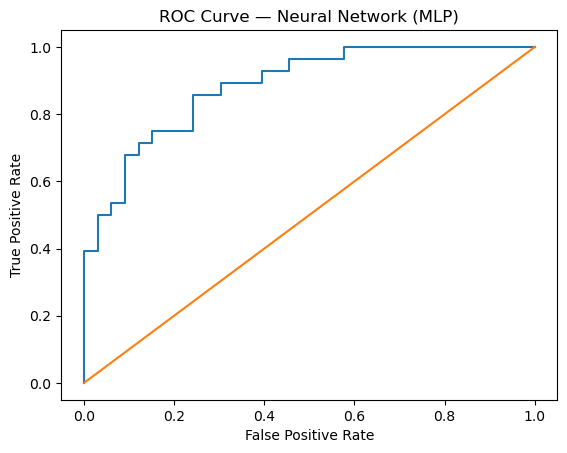

In [79]:
# 14.3) ROC curve (test)
fpr, tpr, _ = roc_curve(y_test, mlp_res["proba"])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.title("ROC Curve — Neural Network (MLP)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



Neural networks are not superior to previous models, especially on small, structured clinical datasets.
Recall is also quite lacking.

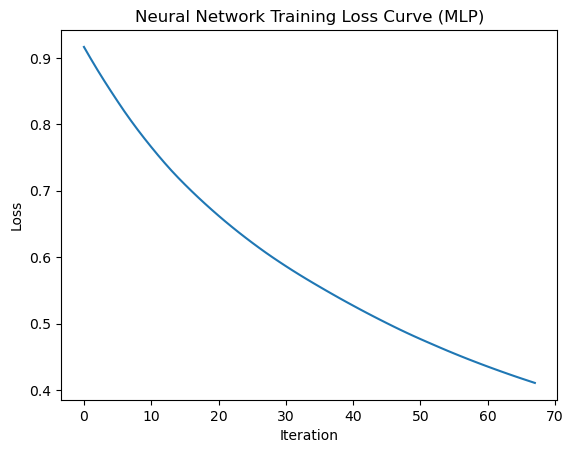

In [80]:
# 14.4) Training loss curve (optimization diagnostic)
# loss_curve_ exists on the fitted MLPClassifier inside the pipeline
loss_curve = mlp.named_steps["clf"].loss_curve_

plt.figure()
plt.plot(loss_curve)
plt.title("Neural Network Training Loss Curve (MLP)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()



The loss curve shows successful training so optimization itself is not the problem.

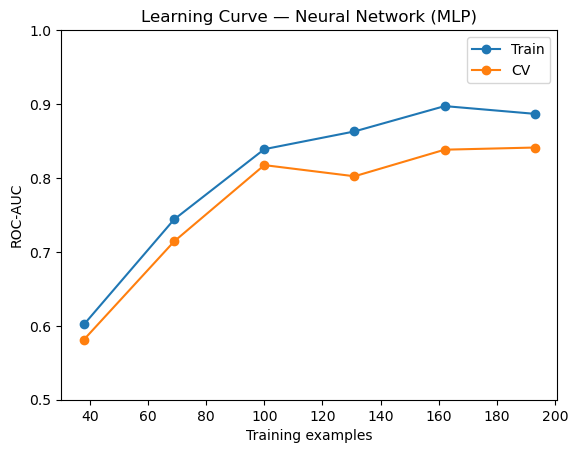

In [81]:
# 14.5) Learning curve (bias–variance diagnostic)
# Uses CV on the training set only (does NOT use the test set)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    mlp,
    X_train, y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.2, 1.0, 6),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o")
plt.plot(train_sizes, val_mean, marker="o")
plt.title("Learning Curve — Neural Network (MLP)")
plt.xlabel("Training examples")
plt.ylabel("ROC-AUC")
plt.legend(["Train", "CV"])
plt.ylim(0.5, 1.0)
plt.show()

The MLP is learning meaningful nonlinear structure, but the dataset size limits its generalization. It seems classical models remain superior for tabular clinical data at this scale.

When using neural networks, **explainability** may be an issue.

Let's look at some ways to understand results from neural networks, starting with **SHAP**.

  0%|          | 0/61 [00:00<?, ?it/s]

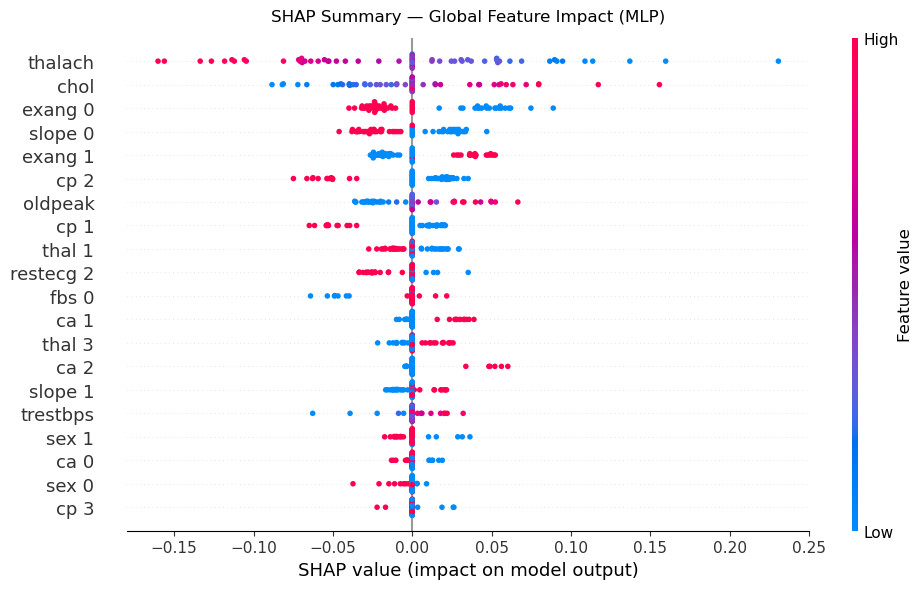

In [98]:
def clean_feature_names(names):
    return (
        pd.Series(names)
        .astype(str)
        .str.replace("cat__", "", regex=False)
        .str.replace("num__", "", regex=False)
        .str.replace("_", " ")
        .tolist()
    )


# Transform data exactly as pipeline does

X_train_trans = mlp.named_steps["prep"].transform(X_train)
X_test_trans  = mlp.named_steps["prep"].transform(X_test)

X_train_trans = X_train_trans.toarray() if hasattr(X_train_trans, "toarray") else X_train_trans
X_test_trans  = X_test_trans.toarray()  if hasattr(X_test_trans, "toarray")  else X_test_trans

# Feature names after preprocessing
try:
    feat_names = mlp.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = [f"f{i}" for i in range(X_train_trans.shape[1])]

feat_names_clean = clean_feature_names(feat_names)
# SHAP 

try:
    import shap

    rng = np.random.default_rng(42)

    # Background sample (smaller = faster)
    bg_size = min(100, X_train_trans.shape[0])
    bg_idx = rng.choice(X_train_trans.shape[0], size=bg_size, replace=False)
    background = X_train_trans[bg_idx]

    # Explain subset of test points for speed
    explain_size = min(200, X_test_trans.shape[0])
    ex_idx = rng.choice(X_test_trans.shape[0], size=explain_size, replace=False)
    X_explain = X_test_trans[ex_idx]

    clf = mlp.named_steps["clf"]

    # KernelExplainer expects a function returning (n_samples,) for a single output
    def predict_proba_pos(X):
        return clf.predict_proba(X)[:, 1]

    explainer = shap.KernelExplainer(predict_proba_pos, background)
    shap_values = explainer.shap_values(X_explain, nsamples=200)

    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=feat_names_clean,
        show=False,
        plot_size=(10, 6)
    )
    plt.title("SHAP Summary — Global Feature Impact (MLP)", fontsize=12, pad=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nSHAP failed with error:\n", repr(e))




In this graph, each dot = one patient, and the X-axis (SHAP value) shows the contribution to predicted heart disease risk, either toward disease (> 0) or no disease (<0), and high feature value in red and low feature value in blue. Features are ranked from top to bottom by overall importance (mean absolute SHAP value).
**Most important features are**:
* max heart rate with low values (blue) increasing disease risk
* cholesterol with high values (red) increasing disease risk
* exercise-induced angina absent is protective
* absence of ST segment slope during exercise is protective

The list doesn't overlap with lists from previous models.

For an individual patient, **LIME** is useful.


LIME explanation (top features) for one patient:
[('thalach <= -0.71', 0.213987419018555), ('chol <= -0.68', -0.1052051917516963), ('cp 2 <= 0.00', 0.09148707398829466), ('exang 0 <= 0.00', 0.0793083842753228), ('cp 1 <= 0.00', 0.0717607992206756), ('ca 2 <= 0.00', -0.06847780570216505), ('0.00 < exang 1 <= 1.00', 0.06458485800544266), ('slope 0 <= 0.00', 0.06423474112234437), ('oldpeak > 0.47', 0.06100912783964429), ('thal 1 <= 0.00', 0.04787223759927009)]


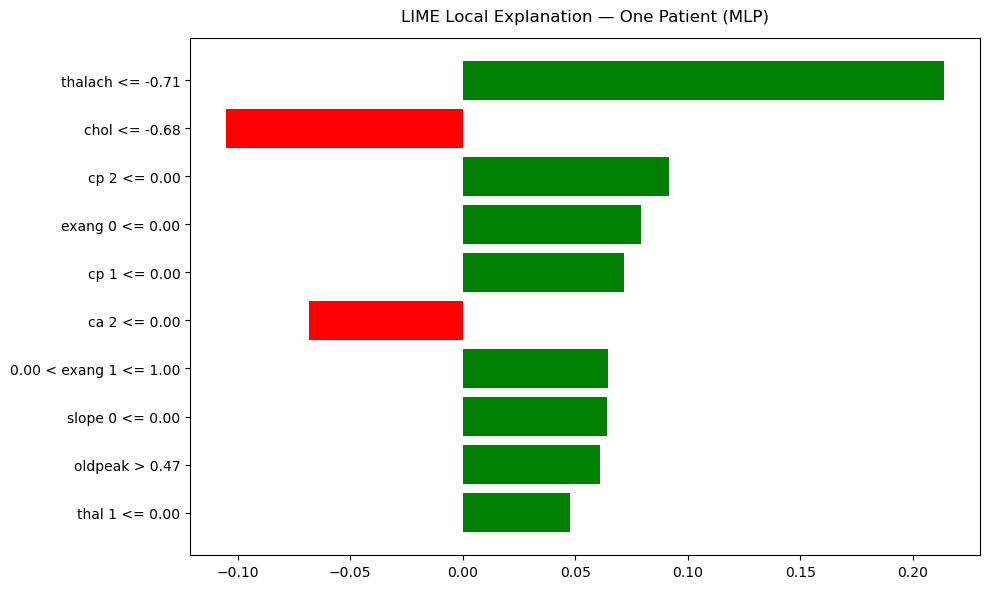


Done.


In [99]:
#LIME

try:
    from lime.lime_tabular import LimeTabularExplainer

    lime_explainer = LimeTabularExplainer(
        training_data=X_train_trans,
        feature_names=feat_names_clean,
        class_names=["No Disease", "Disease"],
        mode="classification",
        discretize_continuous=True
    )

    patient_idx = 0

    # Predict function must accept transformed features (same space as LIME data)
    def predict_proba_transformed(X):
        return mlp.named_steps["clf"].predict_proba(X)

    exp = lime_explainer.explain_instance(
        data_row=X_test_trans[patient_idx],
        predict_fn=predict_proba_transformed,
        num_features=10
    )

    print("\nLIME explanation (top features) for one patient:")
    print(exp.as_list())

    fig = exp.as_pyplot_figure()
    fig.set_size_inches(10, 6)
    plt.title("LIME Local Explanation — One Patient (MLP)", fontsize=12, pad=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nLIME failed with error:\n", repr(e))

print("\nDone.")

In [100]:
patient_idx = 0

y_true = y_test.iloc[patient_idx]
y_pred = mlp.predict(X_test.iloc[[patient_idx]])[0]
y_proba = mlp.predict_proba(X_test.iloc[[patient_idx]])[0, 1]

print("True label:", y_true)
print("Predicted label:", y_pred)
print("Predicted probability (Disease):", round(y_proba, 3))

True label: 1
Predicted label: 1
Predicted probability (Disease): 0.775


For the selected patient **correctly predicted as a risk**, the neural network’s prediction is primarily driven by reduced maximal heart rate and exercise-induced angina, indicating impaired cardiovascular response to stress. Although low cholesterol and fewer affected vessels exert a protective effect, these are insufficient to counterbalance functional ischemic markers. 

## 5. Training time comparison

Finally, let's compare the training time between the different models. 
We can observe the training times are not linked to performance.

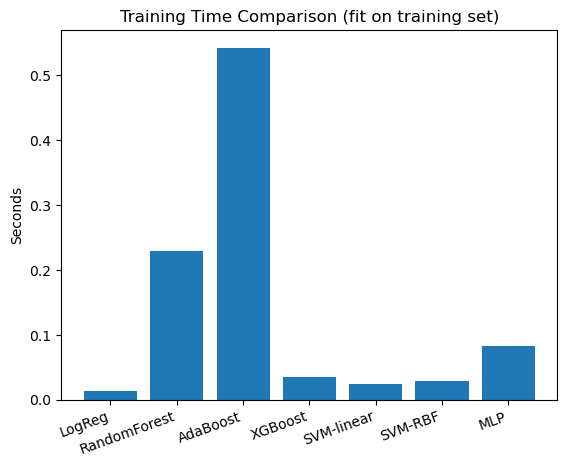

In [93]:
def time_fit(model, name):
    t0 = time.time()
    model.fit(X_train, y_train)
    return name, (time.time() - t0)

candidates = [
    ("LogReg", baseline_lr),
    ("RandomForest", rf_basic),
    ("AdaBoost", ada),
   ("XGBoost", xgb_basic),
    ("SVM-linear", svm_linear),
    ("SVM-RBF", svm_rbf),
    ("MLP", mlp)
]


times = [time_fit(m, n) for n, m in candidates]
plt.figure()
plt.bar([t[0] for t in times], [t[1] for t in times])
plt.title("Training Time Comparison (fit on training set)")
plt.ylabel("Seconds")
plt.xticks(rotation=20, ha="right")
plt.show()



Logistic Regression is by far the fastest to train. Its closed-form / convex optimization makes it an excellent baseline and a strong choice when rapid iteration or deployment constraints matter. Results were second best.

Random Forest shows a noticeable jump in training time, reflecting the cost of fitting many decision trees in parallel. This cost was justified as it achieved best results.

AdaBoost is the slowest, as boosting trains models sequentially, with each learner depending on the previous one—making it more computationally expensive.

SVM with RBF kernel takes slightly longer due to kernel computations, but remains relatively efficient at this dataset size.

The MLP was pretty small, so not that computationally expensive.